# Heterogeneous medium

In [1]:
# ! pip install -e ../../../../jwave

In [2]:
# ! pip install git+https://github.com/ivanmkc/jwave.git@experimental k-wave-python

In [3]:
# ! pip install jwave
# ! pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# ! pip install "jaxlib[cuda]"

In [4]:
# %load_ext line_profiler

In [5]:
# ! which python

In [6]:
import numpy as np

from jax import jit
from jax import numpy as jnp
from jaxdf import FourierSeries
from matplotlib import pyplot as plt

from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import *
from jwave.geometry import circ_mask
from jwave.utils import show_field, show_positive_field

# domain = Domain((320, 320), (50e-3/220, 50e-3/220))
# pml_size_points = np.array((15, 10, 10))  # [grid points]
# grid_size_points = np.array((256, 256, 128)) - 2 * pml_size_points  # [grid points]

pml_size = 10
pml_size_points = np.array((pml_size, pml_size, pml_size))  # [grid points]
# grid_size_points = np.array((128, 128, 64)) - 2 * pml_size_points  # [grid points]
grid_size_points = np.array((256, 64, 128)) - 2 * pml_size_points  # [grid points]

grid_size_meters = 50e-3  # [m]
grid_spacing_meters = grid_size_meters / np.array([grid_size_points[0], grid_size_points[0], grid_size_points[0]])

domain = Domain(tuple(grid_size_points.tolist()), tuple(grid_spacing_meters.tolist()))

In [7]:
# print("Grid dimensions in meters")
print(np.array(domain.N) * np.array(domain.dx))

[0.05       0.00932203 0.02288136]


In [8]:
print("Grid dimensions in inches")
m_to_inches = 39.3701
print(m_to_inches* np.array(domain.N) * np.array(domain.dx))

Grid dimensions in inches
[1.968505   0.36700941 0.90084127]


# Define the medium

In [9]:
sound_speed_background = 1540  # Background sound speed [m/s]
density_background = 1000  # Background density [kg/m^3]

sound_speed_map=sound_speed_background * np.ones(domain.N)
density_map=density_background * np.ones(domain.N)

# Define a random distribution of scatterers for the medium
background_map_mean = 0
background_map_std = 15
sound_speed_map += background_map_std * np.random.randn(domain.N[0], domain.N[1], domain.N[2])
density_map += background_map_std * np.random.randn(domain.N[0], domain.N[1], domain.N[2])

In [10]:
max_freq = sound_speed_background/(2*np.min(domain.dx))

max_freq

3634399.9999999995

In [11]:
# medium = Medium(domain=domain, sound_speed=sound_speed_background)
# medium = Medium(domain=domain, sound_speed=sound_speed_background, density=density_map, pml_size=pml_size)
# time_axis = TimeAxis.from_medium(medium, cfl=0.3)
# time_axis = TimeAxis.from_medium(medium, cfl=0.2, t_end=time_axis.t_end*3)

In [12]:
import numpy as np

# Layer properties
layer_thicknesses = np.array([0.03, 0.02, 0.04])  # e.g., Drywall, Wood, Insulation, Air Gap, Drywall

# Define the sound speed and density values for each layer according to common building materials
layer_sound_speeds = [1500, 3300, sound_speed_background]  # Sound speed values for Drywall, Wood, Insulation, Air Gap, Background
layer_densities = [800, 600, density_background]  # Density values for Drywall, Wood, Insulation, Air Gap, Background

# Get the dimensions of the kgrid
Nx, Ny, Nz = domain.N

# # Set each layer separately in a for loop
# end_index = Ny
# for i, thickness in enumerate(layer_thicknesses[::-1]):  # Reverse the order of layers
#     start_index = end_index - int(thickness / domain.dx[1])
#     print(f"start_index = {start_index}, end_index = {end_index}")
#     # Reverse the order of sound speeds and densities for proper layering
#     sound_speed_map[:, start_index:end_index] = layer_sound_speeds[::-1][i]
#     density_map[:, start_index:end_index] = layer_densities[::-1][i]
#     end_index = start_index

In [13]:
from kwave.data import Vector
from kwave.utils.mapgen import make_ball

# Define a random distribution of scatterers for the medium
background_map_mean = 1
background_map_std = 0.008
background_map = background_map_mean + background_map_std * np.random.randn(Nx, Ny, Nz)

sound_speed_map = sound_speed_background * background_map
density_map = density_background * background_map

# Define a random distribution of scatterers for the highly scattering region
scattering_map = np.random.randn(Nx, Ny, Nz)
scattering_c0 = np.clip(sound_speed_background + 25 + 75 * scattering_map, 1400, 1600) * 2
scattering_rho0 = scattering_c0 / 1.5

# Define a sphere for a highly scattering region
radius = 3e-3
x_pos = 32e-3
y_pos = domain.dx[1] * Ny / 2
z_pos = domain.dx[2] * Nz * 2 / 3
ball_center = np.round(Vector([x_pos, y_pos, z_pos]) / domain.dx[0])
scattering_region1 = make_ball(Vector(domain.N), ball_center, round(radius / domain.dx[0])).nonzero()

sound_speed_map[scattering_region1] = scattering_c0[scattering_region1]
density_map[scattering_region1] = scattering_rho0[scattering_region1]

In [14]:
domain.dx[1]

0.00021186440677966104

In [15]:
ball_center

Vector([151.,  22.,  72.])

In [16]:
sound_speed_map.shape

(236, 44, 108)

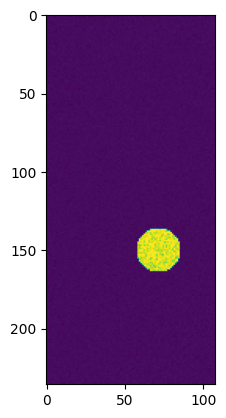

In [17]:
plt.imshow(sound_speed_map[:, domain.N[1]//2, :])

In [18]:
# from jwave.geometry import circ_mask

# circle_mask = np.zeros(domain.N)

# circle_center = np.array(domain.N)*np.array([3/4, 3/4])

# circle_mask += circ_mask(domain.N, 20, np.array(domain.N)/np.array([4, 2.5]))
# # circle_mask += circ_mask(domain.N, 10, circle_center)
# # circle_mask += circ_mask(domain.N, 10, np.array(domain.N)/np.array([2, 3]))
# # circle_mask += circ_mask(domain.N, 10, np .array(domain.N)/np.array([4, 4]))
# circle_mask += circ_mask(domain.N, 10, np.array(domain.N)*np.array([3.4/4, 3/5]))
# # circle_mask += circ_mask(domain.N, 10, np.array(domain.N)*np.array([3/4, 1/5]))
# circle_mask = circle_mask.astype(bool)

# # sound_speed_map[circle_mask] = 250
# # density_map[circle_mask] = 700

# # Define a random distribution of scatterers for the medium
# # background_map_mean = 0
# # background_map_std = 25
# # sound_speed_map += circle_mask * background_map_std * np.random.randn(domain.N[0], domain.N[1])
# # density_map += circle_mask * background_map_std * np.random.randn(domain.N[0], domain.N[1])

# scattering_map = np.random.randn(domain.N[0], domain.N[1])
# scattering_c0 = np.clip(1540 + 25 + 75 * scattering_map, 1400, 1600)
# scattering_rho0 = scattering_c0 / 1.5

# sound_speed_map[circle_mask] = scattering_c0[circle_mask]
# density_map[circle_mask] = scattering_rho0[circle_mask]

In [19]:
# np.histogram(scattering_c0.flatten())

In [20]:
# DOMAIN_EDGE_OFFSET = pml_size

# print(f"y = {domain.N[1]-DOMAIN_EDGE_OFFSET}")

In [21]:
# sound_speed_map[:, domain.N[1]-DOMAIN_EDGE_OFFSET:domain.N[1]] = 2000
# density_map[:, domain.N[1]-DOMAIN_EDGE_OFFSET:domain.N[1]] = 700

## Visualize medium

In [22]:
# medium = Medium(domain=domain, sound_speed=sound_speed_background)
# medium = Medium(domain=domain, sound_speed=sound_speed_background, pml_size=pml_size)
# medium = Medium(domain=domain, sound_speed=np.expand_dims(sound_speed_map, axis=-1), pml_size=pml_size)

medium = Medium(domain=domain, sound_speed=np.expand_dims(sound_speed_map, axis=-1), density=np.expand_dims(density_map, axis=-1), pml_size=pml_size)

time_axis = TimeAxis.from_medium(medium, cfl=0.3)

In [23]:
# show_positive_field(density_map, aspect=None)
# _ = plt.title("Density")

In [24]:
# show_positive_field(sound_speed_map, aspect=None)
# _ = plt.title("sound_speed")

# Signal source

In [25]:
from kwave.utils.signals import tone_burst

# Define the acoustic source
source_frequency = 1e6  # Source frequency [Hz]
source_amplitude = 10 # Source amplitude [Pa]
source_num_cycles = 4  # Number of cycles in the source tone burst

input_signal = source_amplitude * jnp.squeeze(tone_burst(1 / time_axis.dt, source_frequency, source_num_cycles))  # Create the source signal
# input_signal = (source_amplitude / (sound_speed_background * density_background)) * input_signal
assert source_frequency <= max_freq


t = jnp.arange(0, time_axis.t_end, time_axis.dt)

pad_width = t.shape[0] - len(input_signal)
padded_signal = jnp.pad(input_signal, (0, pad_width), mode='constant')

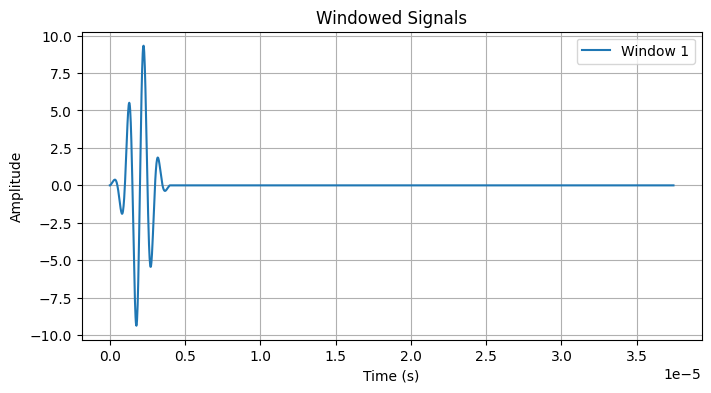

In [26]:
# Plot padded signal
from jwave.signal_processing import gaussian_window
import jax.numpy as jnp
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(t, padded_signal, label='Window 1')
# plt.plot(t, s2, label='Window 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Windowed Signals')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Sources
sources_x = [domain.N[0] // 8]
sources_y = [domain.N[1] // 2]
sources_z = [domain.N[2] // 2]

sources = Sources(
    # positions=([domain.N[0]//2], [domain.N[1]//6]),
    positions=(sources_x, sources_y, sources_z),
    signals=jnp.stack([padded_signal]),
    dt=time_axis.dt,
    domain=domain,
)

# Plot pressure field

Create a point signal source (using above signal) and simulate the pressure field.
Since `simulate_wave_propagation` has no sensors passed to it, it will return the entire pressure field as if sensors were placed everywhere in the domain.

In [28]:
import jaxdf
from typing import Any, Optional
from jwave.geometry import Sources

@jit
def compiled_simulator(
    medium,
    time_axis,
    sound_speed_field,
    density_field, 
    initial_pressure,
    sources=None
):
    pressure = simulate_wave_propagation(
        medium, 
        time_axis, 
        p0=initial_pressure, 
        sources=sources)
    
    return pressure

In [29]:
%%time

pressure_combined_raw = compiled_simulator(medium=medium,
                                           time_axis=time_axis,
                                           sound_speed_field=sound_speed_map,
                                           density_field=density_map,
                                           initial_pressure=None,
                                           sources=sources).on_grid

CPU times: user 9min 55s, sys: 10.1 s, total: 10min 5s
Wall time: 1min 51s


In [30]:
# %%time
# # DEBUG

# from matplotlib import pyplot as plt

# from jwave.geometry import Domain
# from jwave.utils import show_field, show_positive_field

# # N, dx = (64, 64, 64), (0.1e-3, 0.1e-3, 0.1e-3)
# # domain = Domain(N, dx)

# from jax import numpy as jnp

# from jwave.geometry import Medium, Sensors, TimeAxis, fibonacci_sphere, sphere_mask

# # medium = Medium(domain=domain, sound_speed=1500.0)

# # time_axis = TimeAxis.from_medium(medium, cfl=0.3)
# # output_time_axis = TimeAxis(time_axis.dt * 20, time_axis.t_end // 2)

# # sensors
# num_sensors = 6
# x, y, z = fibonacci_sphere(num_sensors, 20, (32, 32, 32))
# sensors_positions = (jnp.array(x), jnp.array(y), jnp.array(z))
# sensors = Sensors(positions=sensors_positions)

# from jwave import FourierSeries
# from jwave.utils import show_field

# # Initial pressure is a sphere
# p0 = jnp.zeros(domain.N)
# p0 = (
#     sphere_mask(domain.N, 5, (32, 36, 36)) * 1.0

In [31]:
# )
# p0 = jnp.expand_dims(p0, -1)

# p0 = FourierSeries(p0, domain)
# p0_slice = p0.on_grid[32]

# show_field(p0_slice, "Section of the initial pressure")

# from jax import jit

# from jwave.acoustics import simulate_wave_propagation

# @jit
# def compiled_simulator(p0):
#     return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)

# pressure = compiled_simulator(p0)

# plt.imshow(pressure[..., 0].T, aspect="auto", cmap="RdBu", vmin=-0.1, vmax=0.1)
# plt.title("Sensors traces")

## Plot pressure field at final time 

In [32]:
from jwave.extras.export import save_video

video_data = pressure_combined_raw[:, :, pressure_combined_raw.shape[2] // 2, :, :]

save_video(FourierSeries(video_data, Domain(domain.N[:-1], domain.dx[:-1])), './output.mp4', vmax=0.05, vmin=-0.05, fps=50)

100%|██████████| 1886/1886 [00:03<00:00, 578.29it/s]


In [33]:
pressure_combined_raw = pressure_combined_raw[:, :, pressure_combined_raw.shape[2] // 2, :, :].squeeze()

Text(0.5, 1.0, 'Pressure field at t=3.744041168829426e-05')

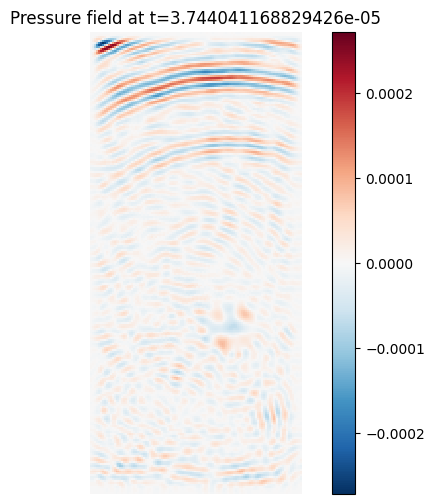

In [34]:
t = -1
show_field(pressure_combined_raw[t], aspect=None)
plt.title(f"Pressure field at t={time_axis.to_array()[t]}")

## Plot and Video

Plot a time lapse and generate a video of the pressure field

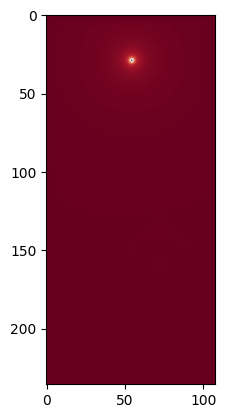

In [35]:
# Max pressure
plt.imshow(jnp.max(pressure_combined_raw, axis=0), aspect=None, cmap="RdBu")

In [36]:
import jax.numpy as jnp

In [37]:
pressure_combined_raw[124].shape

(236, 108)

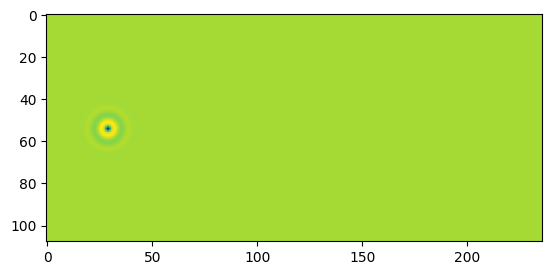

In [38]:
plt.imshow(pressure_combined_raw[124].T)

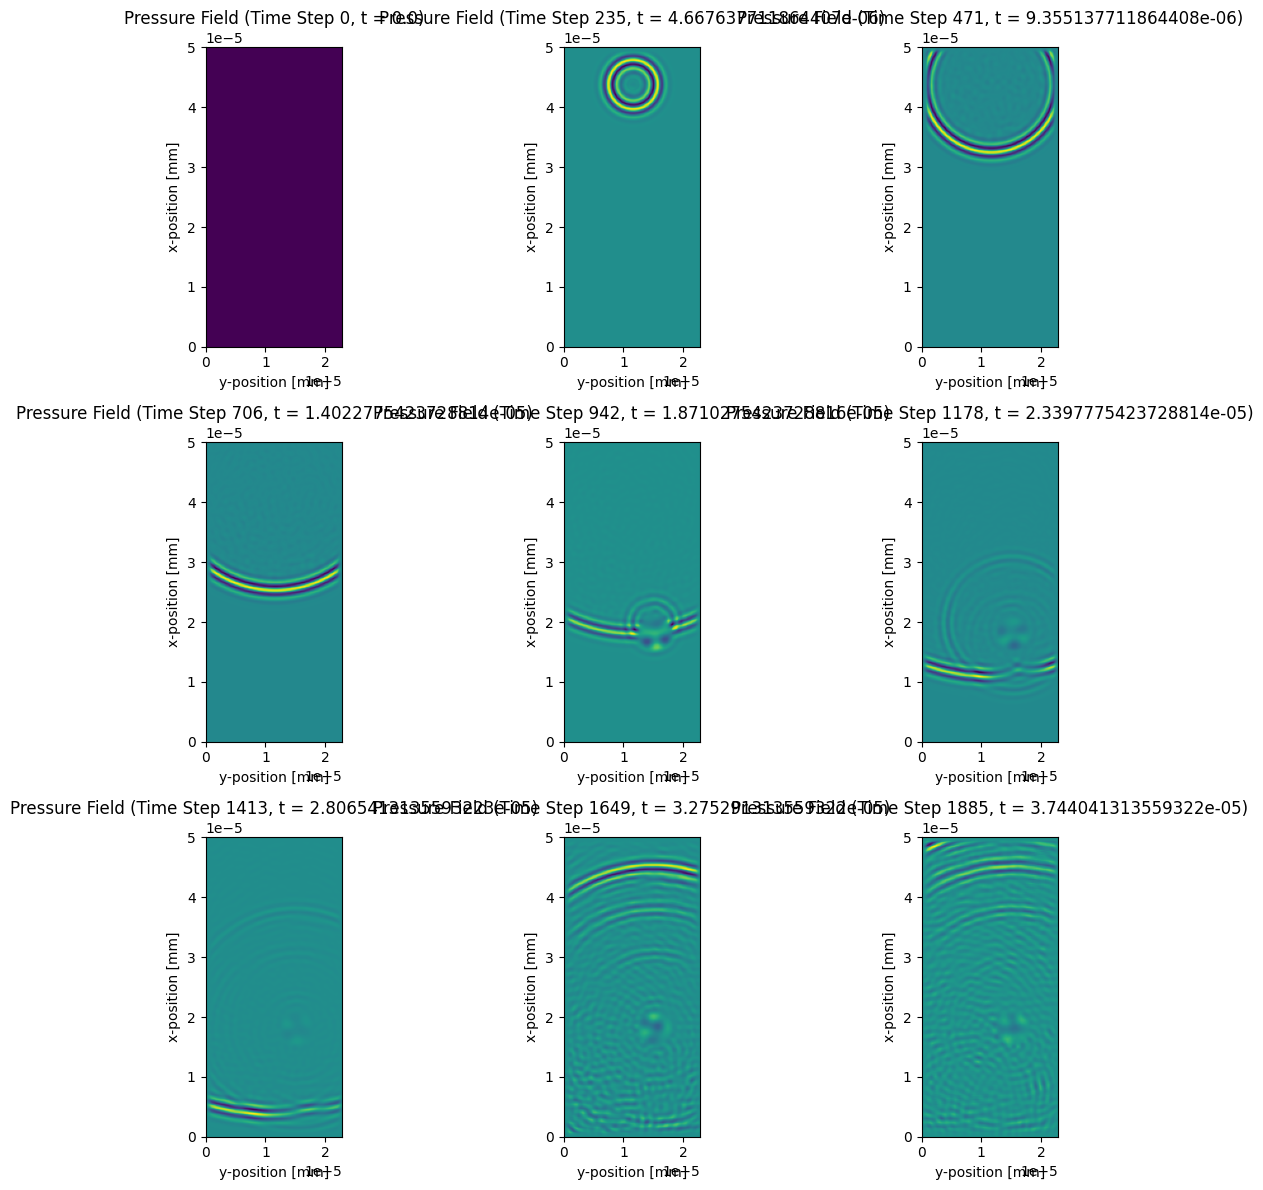

In [39]:
from jwave.experimental import plotting

plotting.plot_pressure_fields(pressure_data=pressure_combined_raw, domain_size=[domain.size[2], domain.size[0]], time_axis_dt=time_axis.dt)

In [40]:
# stop

# Tranducer array

Instead of a point source, we create a `TransducerArray` for the source and the sensor.

In [60]:
import importlib
import jwave
importlib.reload(jwave)
importlib.reload(jwave.geometry)

<module 'jwave.geometry' from '/home/jupyter/jwave/jwave/geometry.py'>

In [61]:
from jwave.geometry import TransducerArray

element_width_in_samples = 6
element_length_in_samples = 40
element_spacing_in_samples = 0

element_width = domain.dx[0] * element_width_in_samples
element_spacing = domain.dx[0] * element_spacing_in_samples
number_elements = domain.N[0]//(element_width_in_samples+element_spacing_in_samples)

# calculate the width of the transducer in grid points
# transducer_width = number_elements * element_width + (number_elements - 1) * element_spacing

position_in_samples = np.round([
    grid_size_points[0] / 2,
    grid_size_points[1] / 2,
    5,
]).astype(int)

position = position_in_samples * domain.dx

transducer_array = TransducerArray(domain=domain,
                                   num_elements=number_elements,
                                   element_width=element_width,
                                   element_height=domain.dx[1]*2,
                                   element_depth=domain.dx[2]*1,
                                   element_spacing=element_spacing,
                                   position=position, 
                                   signal=jnp.stack([padded_signal]),
                                   sound_speed=sound_speed_background,
                                   dt=time_axis.dt,
                                   focus_distance=30e-3, # (domain.N[1] // 2) * domain.dx[1], # halfway in grid
                                   azimuth=0
                                  )

In [62]:
transducer_array.get_segmentation_mask().sum()

18720.0

In [63]:
# plt.imshow(transducer_array.elements[0].mask.on_grid[:, position[1], :, :])

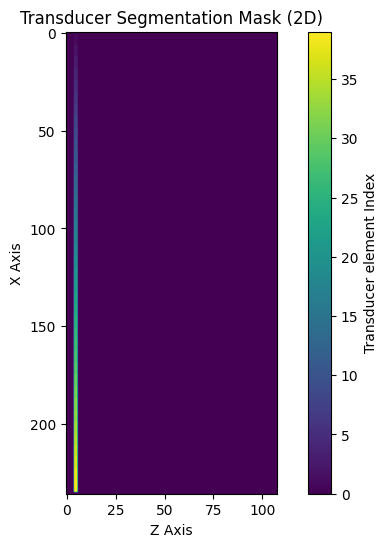

In [64]:
# Assuming transducer_array is an instance of TransducerArray with 2D domain
mask_2d = transducer_array.get_segmentation_mask()
mask_2d = mask_2d[:, position_in_samples[1], :]
plt.figure(figsize=(8, 6))
plt.imshow(mask_2d, cmap='viridis')
plt.colorbar(label='Transducer element Index')
plt.title('Transducer Segmentation Mask (2D)')
plt.xlabel('Z Axis')
plt.ylabel('X Axis')
plt.show()

In [65]:
%%time

p0 = None

def get_sensor_data(sources, sensors):
    sound_speed_field=FourierSeries(np.expand_dims(sound_speed_map, -1), domain)
    density_field=FourierSeries(np.expand_dims(density_map, -1), domain)
    medium = Medium(domain=domain, sound_speed=sound_speed_field, density=density_field, pml_size=pml_size)
    return simulate_wave_propagation(
        medium, 
        time_axis, 
        p0=p0,
        sources=sources, 
        sensors=sensors
    )

transducer_array.set_active_elements(np.ones(transducer_array.num_elements))
sensor_data_onetime = get_sensor_data(sources=transducer_array, sensors=transducer_array)

CPU times: user 15min 40s, sys: 13.2 s, total: 15min 53s
Wall time: 4min 46s


In [66]:
sensor_data_onetime.shape

(1886, 39)

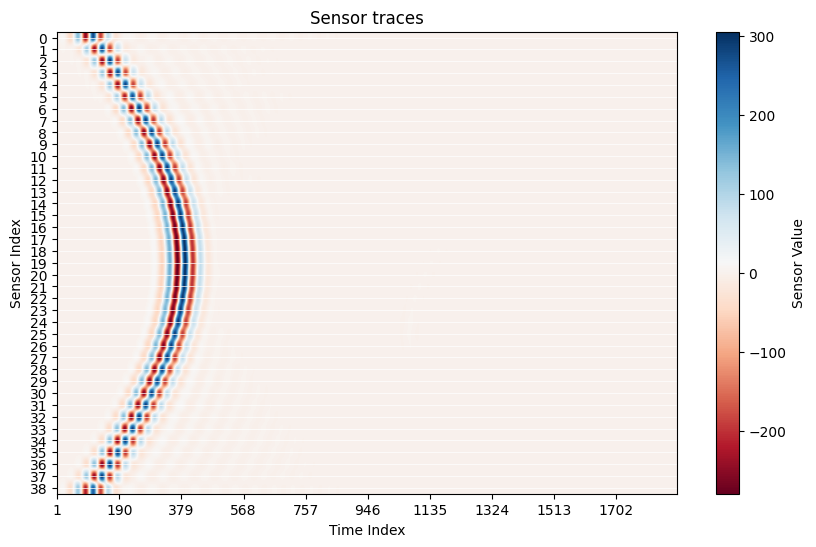

In [67]:
def plot_sensor_data(sensor_data):
    plt.figure(figsize=(10, 6))
    plt.imshow(jnp.expand_dims(sensor_data.T, -1), aspect="auto", cmap="RdBu")
    plt.title("Sensor traces")

    # Add x-axis labels
    plt.xticks(range(0, sensor_data.T.shape[1], round(sensor_data.T.shape[1]/10)), range(1, sensor_data.T.shape[1] + 1, round(sensor_data.T.shape[1]/10)))
    plt.xlabel("Time Index")

    # Add y-axis labels
    plt.yticks(range(0, sensor_data.T.shape[0]), range(0, sensor_data.T.shape[0]))
    plt.ylabel("Sensor Index")

    # Add grid lines
    plt.grid(which="major", axis="y", linestyle="-", linewidth=0.5, color="white")
 
    # Adjust tick positions
    plt.colorbar(label="Sensor Value")
    
plot_sensor_data(sensor_data_onetime)

In [68]:
# transducer_array.set_active_elements([False, False, False, False])
# transducer_array.elements[0].is_active = False
# transducer_array.elements[1].set_is_active(True)

# [element.is_active for element in transducer_array.elements]

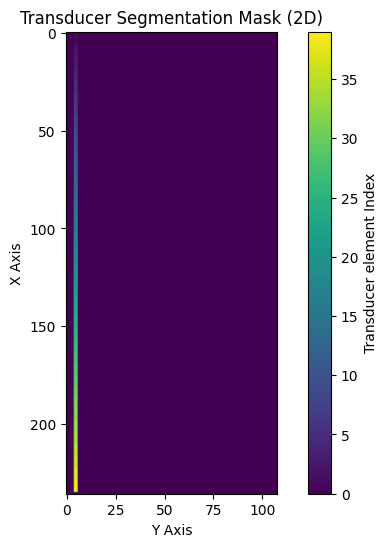

In [75]:
# Assuming transducer_array is an instance of TransducerArray with 2D domain
mask_2d = transducer_array.get_segmentation_mask()
mask_2d = mask_2d[:, position_in_samples[1], :]

plt.figure(figsize=(8, 6))
plt.imshow(mask_2d, cmap='viridis')
plt.colorbar(label='Transducer element Index')
plt.title('Transducer Segmentation Mask (2D)')
plt.xlabel('Y Axis')
plt.ylabel('X Axis')

plt.show()

# Transducer max pressure test

In [76]:
focus_distance_z_per_scan = ball_center[2] * domain.dx[2]

In [79]:
transducer_array.elevation

Array(-90., dtype=float32)

In [81]:
# Set the middle transducer on
idx = transducer_array.num_elements // 2
active_elements = np.zeros(transducer_array.num_elements)
active_elements[idx] = 1
middle_element_pos = transducer_array.elements[idx].center_pos

new_target_point = (middle_element_pos[0], middle_element_pos[1],  middle_element_pos[2] + focus_distance_z_per_scan)
transducer_array.set_target_point(new_target_point)
# active_elements = np.ones(transducer_array.num_elements)

transducer_array.set_active_elements(active_elements)
sensor_data = get_sensor_data(sources=transducer_array, sensors=None)

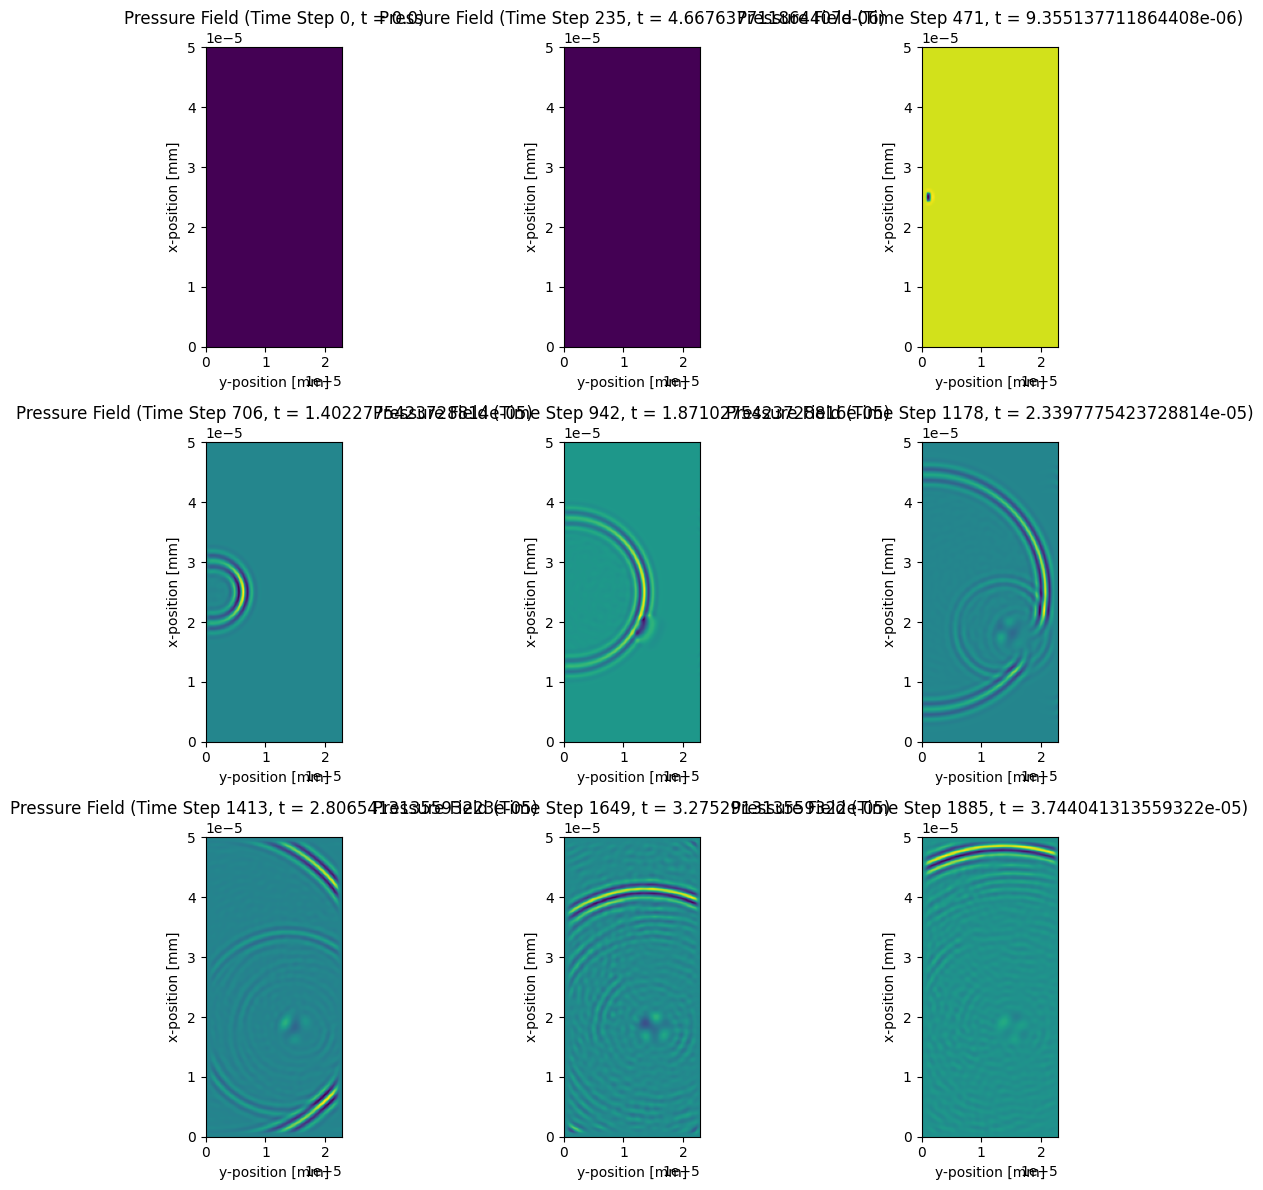

In [99]:
# plotting.plot_pressure_fields(pressure_data=sensor_data.on_grid, domain_size=domain.size, time_axis_dt=time_axis.dt)
sensor_data_2d = sensor_data.on_grid[:, :, sensor_data.on_grid.shape[2] // 2, :, :]
plotting.plot_pressure_fields(pressure_data=sensor_data_2d, domain_size=[domain.size[2], domain.size[0]], time_axis_dt=time_axis.dt)

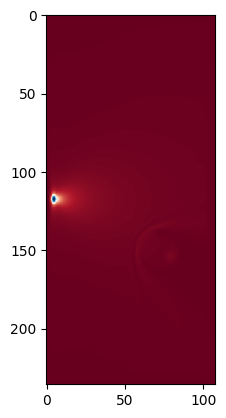

In [87]:
# Plot max sensor data
plt.imshow(jnp.max(sensor_data_2d, axis=0), aspect=None, cmap="RdBu")

In [100]:
from jwave.extras.export import save_video

# save_video(sensor_data_2d, './output_transducer.mp4', vmax=0.05, vmin=-0.05, fps=50)
save_video(FourierSeries(sensor_data_2d, Domain(domain.N[:-1], domain.dx[:-1])), './output_transducer.mp4', vmax=0.05, vmin=-0.05, fps=50)

100%|██████████| 1886/1886 [00:03<00:00, 606.22it/s]


# Create scan lines from first transducer element to the last

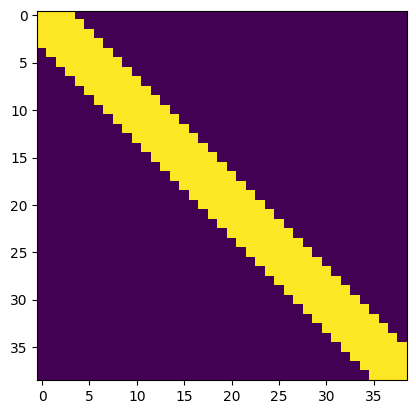

In [101]:
from jwave.experimental.transducer import generate_active_elements

# Range of steering angles to test
# steering_angles = np.arange(-32, 33, 2)
number_scan_lines = transducer_array.num_elements
WINDOW_SIZE = 7
active_elements = generate_active_elements(
    number_scan_lines=number_scan_lines, 
    transducer_number_elements=transducer_array.num_elements, 
    window_size=WINDOW_SIZE)

# Visualize active elements for each scan line
plt.imshow(active_elements)

## Generate scan lines: Method 1

I'm not sure how valid this is. This just offsets each sensor data with the delay during transmission.
However, that means that the reconstruction is only accurate at the focal point, since the offset is non-linear.

In [ ]:
from jwave.experimental import reconstruction
# def run_scan_lines(create_from_scratch):
scan_lines_simple = np.zeros((int(time_axis.Nt), number_scan_lines))
scan_lines_nobeamform = np.zeros((int(time_axis.Nt), transducer_array.num_elements, number_scan_lines,))

for scan_index in range(number_scan_lines):
    print(f'Computing scan line {scan_index+1} of {number_scan_lines}')

    # Update the current active elements
    transducer_array.set_active_elements(active_elements[scan_index])    

    # Update the target position
    active_elements_indices = np.nonzero(active_elements[scan_index])[0]    
    middle_active_element = active_elements_indices[len(active_elements_indices) // 2]

    # print(f"middle_active_element: {middle_active_element}")

    middle_element_pos = transducer_array.elements[middle_active_element].center_pos

    # print(f"middle_element_pos: {middle_element_pos}")

    new_target_point = (middle_element_pos[0], middle_element_pos[1], middle_element_pos[2] + focus_distance_z_per_scan)

    # print(f"new_target_point: {new_target_point}, focus_distance: {transducer_array.focus_distance}, steering_angle: {transducer_array.steering_angle}")

    transducer_array.set_target_point(new_target_point)    

    sensor_data = get_sensor_data(sources=transducer_array, sensors=transducer_array)

    # scan_lines_nobeamform[:, :, scan_index] = sensor_data
    scan_lines_nobeamform[:, active_elements[scan_index].astype(bool), scan_index] = sensor_data

    # scan_lines[:, scan_index] = transducer_array.scan_line(sensor_data) # [:int(time_axis.Nt)]
    scan_line = transducer_array.scan_line(sensor_data)

    scan_line_trimmed = reconstruction.trim_scan_lines(
        scan_lines=jnp.expand_dims(scan_line, -1),
        input_signal=input_signal,
        max_delay_in_samples=transducer_array.max_delay_in_samples
    ).squeeze()

    # plt.plot(scan_line[transducer_array.max_delay_in_samples:])
    # scan_lines[:, scan_index] = scan_line[transducer_array.max_delay_in_samples:]
    scan_lines_simple[:, scan_index] = scan_line_trimmed
    # print(f"scan_line.shape: {scan_line.shape}")
    # print(f"scan_line_trimmed.shape: {scan_line_trimmed.shape}")
    # print(transducer_array.max_delay_in_samples)

        # return scan_lines

Computing scan line 1 of 39
Computing scan line 2 of 39
Computing scan line 3 of 39
Computing scan line 4 of 39
Computing scan line 5 of 39
Computing scan line 6 of 39
Computing scan line 7 of 39
Computing scan line 8 of 39
Computing scan line 9 of 39
Computing scan line 10 of 39
Computing scan line 11 of 39
Computing scan line 12 of 39
Computing scan line 13 of 39
Computing scan line 16 of 39
Computing scan line 17 of 39
Computing scan line 18 of 39
Computing scan line 19 of 39
Computing scan line 20 of 39
Computing scan line 21 of 39
Computing scan line 22 of 39
Computing scan line 23 of 39
Computing scan line 24 of 39
Computing scan line 25 of 39
Computing scan line 30 of 39
Computing scan line 31 of 39
Computing scan line 32 of 39


In [ ]:
ax = plot_sensor_data(scan_lines_simple)

# Sense-making scan-line algorithm that takes depth into account properly

This slower approaches calculates the time delay for each reconstruction pixel (x and y) and picks the closest index in the data corresponding to it.

In [ ]:
# # plt.imshow(sensor_data.T[:, :210], aspect="auto", cmap="RdBu")

# scan_lines = np.zeros((int(time_axis.Nt), number_scan_lines))

# beamform_indices_all = []

# for scan_index in range(0, number_scan_lines):
#     print(f'Computing scan line {scan_index+1} of {number_scan_lines}')
#     transducer_array.set_active_elements(active_elements[scan_index])    

#     # Update the target position
#     active_elements_indices = np.nonzero(active_elements[scan_index])[0]    
#     middle_active_element = active_elements_indices[len(active_elements_indices) // 2]

#     middle_element_pos = transducer_array.elements[middle_active_element].center_pos

#     new_target_point = (middle_element_pos[0], middle_element_pos[1], middle_element_pos[2] + domain.N[2] * domain.dx[2])

#     transducer_array.set_target_point(new_target_point)    

#     # print(new_target_point)

#     sensor_data = get_sensor_data(sources=transducer_array, sensors=transducer_array)

#     num_active_elements = np.sum(active_elements[scan_index])
#     num_time_samples = sensor_data.shape[0]

#     beamform_indices = np.zeros((num_time_samples, num_active_elements))

#     delays_in_samples_middle = jnp.round(
#         TransducerArray.calculate_beamforming_delays(
#             source_positions=jnp.array([middle_element_pos]),
#             target_point=transducer_array.target_point,
#             sound_speed=transducer_array.sound_speed,
#             max_delay=transducer_array.max_delay
#         ) / transducer_array.dt)[0]
#     print(f"delays_in_samples_middle: {delays_in_samples_middle}")

#     for depth_idx in range(0, num_time_samples):
#         # print(f'\tComputing depth line {depth_idx+1} of {num_time_samples}')
        
#         # middle_element_pos = transducer_array.elements[middle_active_element].center_pos

#         scan_target_point = (middle_element_pos[0], middle_element_pos[1] + depth_idx*sound_speed_background*time_axis.dt)

#         # Get active sensors
#         active_sensor_positions = np.array([element.center_pos for element in transducer_array.elements if element.is_active])

#         # Find distance from each sensor to the new target point
#         distances = jnp.sqrt(((active_sensor_positions[:, 0] - scan_target_point[0])**2) +
#                              ((active_sensor_positions[:, 1] - scan_target_point[1])**2))

#         # Calculate sound wave travel times
#         round_trip_time = distances / sound_speed_background 

#         round_trip_time_in_samples = (round(round_trip_time / time_axis.dt))

#         beamform_indices[depth_idx, :] = round_trip_time_in_samples + delays_in_samples_middle

#     # Fix formats
#     sensor_data = np.array(sensor_data)
#     beamform_indices = beamform_indices.astype(int)
#     beamform_indices_all.append(beamform_indices)

#     valid_indices = np.clip(beamform_indices, 0, sensor_data.shape[0] - 1)
#     scan_line = np.sum(sensor_data[valid_indices, np.arange(sensor_data.shape[1])], axis=1)
    
#     # scan_line_trimmed = reconstruction.trim_scan_lines(
#     #     scan_lines=jnp.expand_dims(scan_line, -1),
#     #     input_signal=source_signal,
#     #     max_delay_in_samples=transducer_array.max_delay_in_samples
#     # ).squeeze()    

#     # print(transducer_array.max_delay_in_samples, scan_line.shape, scan_line.shape-)
#     # print(scan_line_trimmed.shape)
#     scan_lines[:, scan_index] = scan_line
    

#         # print(round_trip_time_in_samples)

#         # delay = delays_in_samples[i]
#         # plt.axvline(x=delay, ymin=(i)/num_sensors, ymax=(i+1)/num_sensors, linestyle='--', alpha=0.7)
#         # print(delay)

In [ ]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from typing import List, Tuple

def calculate_beamforming_delays(
    source_positions: jnp.ndarray,
    target_point: jnp.ndarray,
    sound_speed: float,
    max_delay: float
) -> jnp.ndarray:
    """
    Calculate beamforming delays for a set of source positions to a target point.
    
    Args:
        source_positions (jnp.ndarray): Array of source positions.
        target_point (jnp.ndarray): Target point coordinates.
        sound_speed (float): Speed of sound in the medium.
        max_delay (float): Maximum allowable delay.

    Returns:
        jnp.ndarray: Calculated delays in samples.
    """
    distances = jnp.linalg.norm(source_positions - target_point, axis=1)
    travel_times = distances / sound_speed
    delays = travel_times - travel_times.min()
    delays_in_samples = jnp.round(delays / max_delay)
    return delays_in_samples

def compute_beamform_indices(
    num_time_samples: int,
    num_active_elements: int,
    middle_element_pos: Tuple[float, float, float],
    transducer_array: 'TransducerArray',
    sound_speed_background: float,
    time_axis: 'TimeAxis'
) -> np.ndarray:
    """
    Compute beamform indices for each depth level.

    Args:
        num_time_samples (int): Number of time samples.
        num_active_elements (int): Number of active elements in the transducer array.
        middle_element_pos (Tuple[float, float, float]): Position of the middle active element.
        transducer_array (TransducerArray): Transducer array object.
        sound_speed_background (float): Background sound speed.
        time_axis (TimeAxis): Time axis object.

    Returns:
        np.ndarray: Calculated beamform indices.
    """
    beamform_indices = np.zeros((num_time_samples, num_active_elements))

    # Calculate delays for the middle element
    delays_in_samples_middle = calculate_beamforming_delays(
        source_positions=jnp.array([middle_element_pos]),
        target_point=transducer_array.target_point,
        sound_speed=transducer_array.sound_speed,
        max_delay=transducer_array.max_delay
    )[0]

    # Iterate over each depth level
    for depth_idx in range(num_time_samples):
        # Compute the target point at the current depth level
        scan_target_point = (
            middle_element_pos[0],
            middle_element_pos[1],
            middle_element_pos[2] + depth_idx * sound_speed_background * time_axis.dt
        )

        # Get positions of active sensors
        active_sensor_positions = np.array([element.center_pos for element in transducer_array.elements if element.is_active])
        
        # Calculate distances from each sensor to the target point
        distances = jnp.linalg.norm(active_sensor_positions - scan_target_point, axis=1)
        
        # Calculate round trip travel times
        round_trip_time = distances / sound_speed_background
        
        # Convert travel times to samples
        round_trip_time_in_samples = np.round(round_trip_time / time_axis.dt)
        
        # Calculate beamform indices
        beamform_indices[depth_idx, :] = round_trip_time_in_samples + delays_in_samples_middle

    return beamform_indices.astype(int)

def process_scan_lines(
    number_scan_lines: int,
    time_axis: 'TimeAxis',
    transducer_array: 'TransducerArray',
    active_elements: List[np.ndarray],
    sound_speed_background: float
) -> np.ndarray:
    """
    Process scan lines by computing the beamforming indices and aggregating sensor data.

    Args:
        number_scan_lines (int): Total number of scan lines.
        time_axis (TimeAxis): Time axis object.
        transducer_array (TransducerArray): Transducer array object.
        active_elements (List[np.ndarray]): List of active elements for each scan line.
        sound_speed_background (float): Background sound speed.

    Returns:
        np.ndarray: Processed scan lines.
    """
    # Initialize array to store the final scan lines
    scan_lines = np.zeros((int(time_axis.Nt), number_scan_lines))
    beamform_indices_all = []

    # Iterate over each scan line
    for scan_index in range(number_scan_lines):
        print(f'Computing scan line {scan_index+1} of {number_scan_lines}')
        
        # Set active elements for the current scan line
        transducer_array.set_active_elements(active_elements[scan_index])

        # Find the middle active element
        active_elements_indices = np.nonzero(active_elements[scan_index])[0]
        middle_active_element = active_elements_indices[len(active_elements_indices) // 2]
        middle_element_pos = transducer_array.elements[middle_active_element].center_pos

        # Set a new target point deeper in the z-axis direction
        new_target_point = (
            middle_element_pos[0],
            middle_element_pos[1],
            middle_element_pos[2] + domain.N[2] * domain.dx[2]
        )

        # Update the transducer array with the new target point
        transducer_array.set_target_point(new_target_point)

        # Retrieve sensor data
        sensor_data = get_sensor_data(sources=transducer_array, sensors=transducer_array)

        num_active_elements = np.sum(active_elements[scan_index])
        num_time_samples = sensor_data.shape[0]

        # Compute beamforming indices for the current scan line
        beamform_indices = compute_beamform_indices(
            num_time_samples=num_time_samples,
            num_active_elements=num_active_elements,
            middle_element_pos=middle_element_pos,
            transducer_array=transducer_array,
            sound_speed_background=sound_speed_background,
            time_axis=time_axis
        )

        # Store computed beamforming indices
        beamform_indices_all.append(beamform_indices)
        
        # Clip indices to valid range and sum the sensor data accordingly
        valid_indices = np.clip(beamform_indices, 0, sensor_data.shape[0] - 1)
        scan_line = np.sum(sensor_data[valid_indices, np.arange(sensor_data.shape[1])], axis=1)

        # Store the resulting scan line
        scan_lines[:, scan_index] = scan_line

    return scan_lines

# Example usage:
# Assuming you have `time_axis`, `transducer_array`, `active_elements`, `sound_speed_background`, and `domain` defined.
scan_lines = process_scan_lines(number_scan_lines, time_axis, transducer_array, active_elements, sound_speed_background)

In [ ]:
ax = plot_sensor_data(scan_lines[len(input_signal):, :])

In [ ]:
# Compare with "simple" version
ax = plot_sensor_data(scan_lines_simple)

You can see that the relationship between each depth and beamform index is not the same, and certainly not guaranteed to be linear.

The middle element in a scan line would be linear though as the depth line is positioned relative to it.

In [ ]:
# Number of plots equals the number of series
num_plots = beamform_indices_middle_element.shape[1]

# Define the grid size as close to square as possible
rows = int(np.ceil(np.sqrt(num_plots)))
cols = int(np.ceil(num_plots / rows))

# Creating subplots in a grid
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust size as needed
axs = axs.flatten()  # Flatten the 2D array of axes for easier indexing

for i in range(num_plots):
    for j in range(num_plots):
        line_color = 'grey' if i != j else 'blue'
        line_alpha = 0.3 if i != j else 1.0
        line_width = 1 if i != j else 2
        axs[i].plot(beamform_indices_middle_element[:100, j], label=f'Index {j+1}' if i == j else None, 
                    color=line_color, alpha=line_alpha, linewidth=line_width)
    
    axs[i].legend(loc='upper right')
    axs[i].set_title(f'Index {i+1}')
    axs[i].set_xlabel('Sample Index')
    axs[i].set_ylabel('Value')

# Disable unused axes if any
for ax in axs[num_plots:]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Trim signal from scan lines

In [ ]:
scan_lines_trimmed = scan_lines[round(len(source_signal)*1.2):, :]

scan_lines_trimmed.shape

In [ ]:
# Combine elements per scan line

In [ ]:
focus_distance_z_per_scan

In [ ]:
distance_y_in_m = domain.N[1] * domain.dx[1]

grid_edge_in_samples = distance_y_in_m / transducer_array.sound_speed / transducer_array.dt

In [ ]:
transducer_array.dt

In [ ]:
ax = plot_sensor_data(scan_lines)

In [ ]:
ax = plot_sensor_data(scan_lines_trimmed)

source_end_in_samples = int(len(source_signal))
plt.axvline(x=source_end_in_samples, color='cyan', linestyle='-', linewidth=1.5)

focus_depth_in_samples = focus_distance_z_per_scan * 2 / transducer_array.sound_speed / transducer_array.dt

# plt.axvline(x=grid_edge_in_samples, color='g', linestyle='-', linewidth=1.5)
plt.axvline(x=grid_edge_in_samples*2, color='g', linestyle='-', linewidth=1.5)

plt.axvline(x=focus_depth_in_samples + source_end_in_samples, color='magenta', linestyle='-', linewidth=1.5)

In [ ]:
plot_sensor_data(scan_lines_trimmed)

In [ ]:
plot_sensor_data(sensor_data_onetime)

# Post process sensor data

In [ ]:
from kwave.utils.filters import gaussian_filter

scan_lines_fund = gaussian_filter(scan_lines_trimmed.T, 1/time_axis.dt, source_frequency, 100)
scan_lines_harm = gaussian_filter(scan_lines_trimmed.T, 1/time_axis.dt, 2 * source_frequency, 30)

In [ ]:
from kwave.reconstruction.beamform import envelope_detection

scan_lines_fund = envelope_detection(scan_lines_fund)
scan_lines_harm = envelope_detection(scan_lines_harm)

In [ ]:
from kwave.reconstruction.tools import log_compression

compression_ratio = 3
scan_lines_fund = log_compression(scan_lines_fund, compression_ratio, True)
scan_lines_harm = log_compression(scan_lines_harm, compression_ratio, True)

In [ ]:
scan_lines_fund.shape

In [ ]:
def x_extents(self) -> Tuple[float, float]:
    return float(self.elements[0].center_pos[0]), float(self.elements[-1].center_pos[0])

x_extents(transducer_array)

In [ ]:
# image_size = [domain.N[0] * domain.dx[0], domain.N[1] * domain.dx[1]]

# Create the axis variables
x_axis = transducer_array.x_extents()
y_axis = [0, domain.N[1] * domain.dx[1]]
max_y_samples = int(domain.N[1]*domain.dx[1] / transducer_array.sound_speed / time_axis.dt)

scan_lines_fund = scan_lines_fund[:, :max_y_samples*2]

In [ ]:
scan_lines_fund.shape[1] * time_axis.dt/2

In [ ]:
scan_lines_fund.shape[1]*time_axis.dt * transducer_array.sound_speed

In [ ]:
# Calculate the extent to properly map the axes
extent = [y_axis[0], scan_lines_fund.shape[1]*time_axis.dt * transducer_array.sound_speed, x_axis[0], x_axis[1]]

print(extent)

aspect_ratio = (extent[1] - extent[0])/(extent[3] - extent[2])

In [ ]:
np.array(domain.N) * np.array(domain.dx)

In [ ]:

plt.figure(figsize=(20, 20))  # Adjust the figure size as needed
plt.subplot(132)
plt.imshow(scan_lines_fund,
           # aspect=aspect_ratio,
           extent=extent,
           interpolation='none', 
           cmap='bone')
plt.xlabel('Depth [m]')
plt.ylabel('x [m]')
plt.title('Processed Scan-Line Data')
# plt.colorbar(label='Intensity')  # Add a color bar for better understanding of the plot scale

plt.show()

In [ ]:
show_positive_field(sound_speed_map, aspect=None)
_ = plt.title("sound_speed")